## Gradient Boosting Regression to Predict House Prices

I started on Kaggle with this competion and below notebook is highly inflenced by learnings from [Stacked Regressions : Top 4% on LeaderBoard by Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

I have applied following things to come out with my set of predictions for this dataset:
1. Removal of Outliers present in dataset
2. Feature Engineering by imputing missing values
3. Applying log transformation on target variable
4. Applying Box-Cox transformation on skewed variables
5. Getting dummy variables from categorical features

Then, I used the k-fold cross validation technique to improve accuaracy and reduce rmse value for my predictions done thorough Gradient Boosting regression model in sklearn

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew 

import os

In [73]:
# Load training data and testing data
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [74]:
# Store ID columns of train and test before combining these two
train_id_list = train_df['Id']
test_id_list = test_df['Id']

**Outliers Removal**: We are going to remove outliers from this dataset which are clearly mentioned in the [Documentation](http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt)

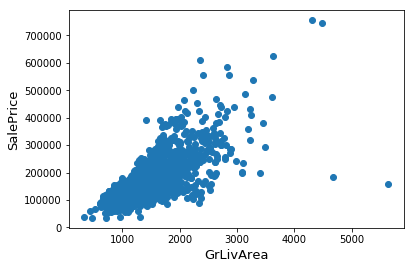

In [75]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

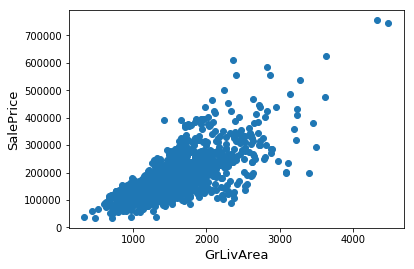

In [76]:
# Deleting outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**Check the distribution of SalesPrice**

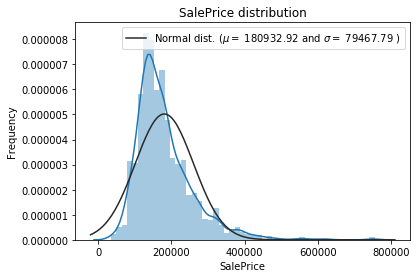

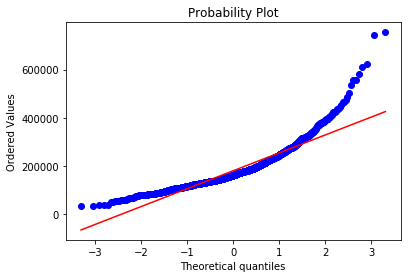

In [77]:
# histogram
sns.distplot(train_df['SalePrice'], fit=norm);
(mu, sigma) = norm.fit(train_df['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

So, we can infer from the above charts that the SalesPrice does not have perfect normal distribution and it has some positive skewness. Let's make this normal by applying log transformation

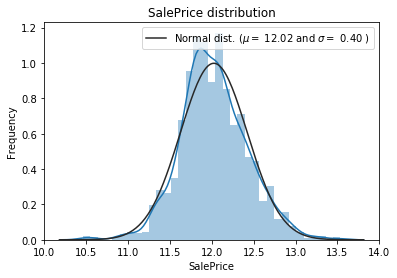

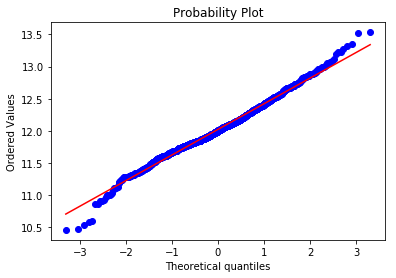

In [78]:
target = np.log(train_df['SalePrice'])
train_df_wo_tar = train_df.drop(['SalePrice'], axis=1)

# histogram
sns.distplot(target, fit=norm);
(mu, sigma) = norm.fit(target)

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()

## **Feature Engineering and Preprocessing**

**Combine train and test data**

In [79]:
# Combine test and train data
combined_df = pd.concat([train_df_wo_tar, test_df], sort=True)

**Check Null Values in the data**

In [80]:
combined_df.isnull().sum()[combined_df.isnull().any() == True].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

**See correlation among variables present in the data**

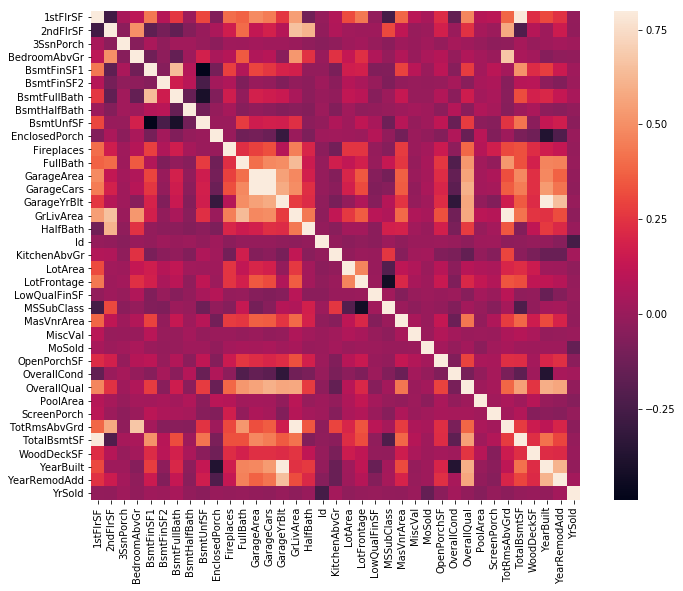

In [81]:
# Plot heatmap to see linear relations between variables
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(combined_df.select_dtypes(exclude=['object']).corr(), vmax=0.8, square=True)
plt.show()

**Replace NAs with None in below variables**

In [82]:
# Replace Categorical variables with None which are scaled later

cat_cols_to_scale = ['ExterQual', 'ExterCond', 'GarageQual', 'GarageCond', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual', 'PoolQC']
combined_df[cat_cols_to_scale] = combined_df[cat_cols_to_scale].fillna('None', axis=1)
combined_df.head(1)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,None,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008


**Convert these variables to numerical variables**

In [83]:
# Scale above variables from 0 to 5
scale_dict = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for col in cat_cols_to_scale:
    combined_df[col] = combined_df[col].map(scale_dict)
    
combined_df.head(1)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,4,150.0,Y,Norm,Norm,SBrkr,0,3,4,VinylSd,VinylSd,NaN,0,0,PConc,2,Typ,548.0,2.0,3,RFn,3,Attchd,2003.0,1710,1,GasA,5,2Story,1,1,4,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,0,CompShg,Gable,Normal,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008


**Modify column Pool Area using Pool QC:** Here we will map the pool quality to average value of pool area to replace missing numbers for pool area

In [84]:
pd.options.mode.chained_assignment = None
avg_pool_area = combined_df.groupby(['PoolQC'])['PoolArea']
scale_dict = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
pool_qc_dict = dict(zip(avg_pool_area.mean(), np.vectorize(scale_dict.get)(avg_pool_area.mean().index.values)))
combined_df['PoolArea'] = combined_df.apply(lambda row: pool_qc_dict[min(avg_pool_area.mean(), key=lambda x:abs(row['PoolArea']-x))] if (row['PoolQC'] == 0) and (row['PoolArea'] > 0) else row['PoolQC'], axis=1)

**See String columns with missing data and replace with None**

In [85]:
# Check null string columns
def get_null_cols(df):
    null_series = df.isnull().sum()
    null_string_cols = []
    for i, v in null_series.iteritems():
        if v > 0 and str(df[i].dtypes) == 'object':
            null_string_cols.append(i)
            unique_vals = df[i].unique().tolist()
            
    return null_string_cols

null_string_cols = get_null_cols(combined_df)
print(null_string_cols)

['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Functional', 'GarageFinish', 'GarageType', 'MSZoning', 'MasVnrType', 'MiscFeature', 'SaleType', 'Utilities']


In [86]:
# Replace null with 'None'
comb_df_nulls_replaced = combined_df
comb_df_nulls_replaced[null_string_cols] = comb_df_nulls_replaced[null_string_cols].fillna('None')

**Replace missing data in numerical columns with median value**

In [87]:
# See non string null columns
non_string_nulls = comb_df_nulls_replaced.isnull().sum()
comb_non_string_nulls = non_string_nulls[non_string_nulls != 0]

In [88]:
# Replace int columns null values with median
for i, v in comb_non_string_nulls.iteritems():
    comb_df_nulls_replaced[i] = comb_df_nulls_replaced[i].replace(np.NaN, comb_df_nulls_replaced[i].median())

In [89]:
all_data = comb_df_nulls_replaced.drop(['Id'], axis=1)
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolQC,19.548879
PoolArea,19.548879
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [90]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if feat != 'Id':
        all_data[feat] = boxcox1p(all_data[feat], lam)

There are 45 skewed numerical features to Box Cox transform


**Do One-Hot Encoding on remaining string variables**

In [91]:
# Do One Hot Encoding
comb_data = pd.get_dummies(all_data)

**Separate train and test data**

In [92]:
comb_data['Id'] = comb_df_nulls_replaced['Id']
train_data = comb_data[comb_data['Id'].isin(train_id_list)]
test_data = comb_data[comb_data['Id'].isin(test_id_list)]

In [93]:
train_data = train_data.drop(['Id'], axis=1)
test_data = test_data.drop(['Id'], axis=1)

## **Modelling**

**Apply K-Fold Validation on Gradient Boosting Regression**

In [94]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [95]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data.values)
    rmse= np.sqrt(-cross_val_score(model, train_data.values, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [96]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [97]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1160 (0.0068)



**Fit the above Gradient Boost Model to train data and predict the test data SalePrice**

In [98]:
clf = GBoost
clf.fit(train_data, target)

y_pred_train = clf.predict(train_data)
print("RMSE train data is %s" % math.sqrt(mean_squared_error(target, y_pred_train)))

RMSE train data is 0.05139890121777695


In [99]:
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
test_set = test_data

In [100]:
predictions = GBoost.predict(test_set)
submission['SalePrice'] = np.exp(predictions)

In [101]:
submission.to_csv('output.csv', index=False)